# Fractions Skill Score Verification - UH & Z - Tornado

In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import xoak
import numpy as np
import matplotlib.pyplot as plt
import regionmask
import cartopy
import cartopy.crs as ccrs
import glob
%matplotlib inline
import pysteps

import warnings
warnings.filterwarnings('ignore')

Pysteps configuration file found at: /home/jcorner1/.local/lib/python3.9/site-packages/pysteps/pystepsrc



### Load the Data

In [2]:
def Data_Conv(ds):
    
    '''
    A defintion  
    
    Parameters
    ----------
    ds: xarray dataset
    
    Returns
    -------
    ds: returns a coarsened data with lat/long
    
    '''
    geog = xr.open_dataset("/home/scratch/WRF_BCC/geography/geo_em.d01.nc")
    geog = geog[['CLAT', 'CLONG']].coarsen(south_north=20, west_east=20, boundary='trim').mean()
    
    ds = ds.coarsen(south_north=20, west_east=20, boundary='trim').sum()
    ds = xr.merge([ds, geog.squeeze()])
    ds = ds.rename({"CLONG": 'lon', 'CLAT': 'lat'})

    ds = ds.assign_coords({'x': ds.west_east, 'y': ds.south_north})
    ds = ds.assign_coords({'lon': ds.lon, 'lat': ds.lat})
    ds.xoak.set_index(['lat', 'lon'], 'sklearn_geo_balltree')
    
    return ds

In [3]:
#load wrf-bcc dataset
#find all csv files for each variable and sort
files_refc = glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_REFC*')
files_uh = glob.glob('/home/scratch/jcorner1/syn_sev/dataframes/HIST_UH*')
files_refc.sort()
files_uh.sort()

#concat all dataframes of same variable type together
df_refc = pd.concat(map(pd.read_csv, files_refc), ignore_index=True)
df_uh = pd.concat(map(pd.read_csv, files_uh), ignore_index=True)

#combine the new dataframes together
df = pd.concat([df_uh, df_refc])

#get rid of the duplicates
df = df.drop_duplicates(subset=['x','y','Time'])
df

,Unnamed: 0,x,y,Time,UH,DBZ,UVV
0,0,753,483,1990-10-31T01:00:00.000000000,35.804810,13.807288,12.857470
1,1,754,483,1990-10-31T01:00:00.000000000,35.848896,37.720950,12.006787
2,2,749,411,1990-10-31T04:00:00.000000000,42.497177,51.801662,17.208110
3,3,750,411,1990-10-31T04:00:00.000000000,41.811430,40.762430,13.348378
4,4,750,412,1990-10-31T04:00:00.000000000,35.797220,40.055344,12.823191
...,...,...,...,...,...,...,...
50369937,3014602,909,700,2005-09-30T00:00:00.000000000,0.241252,40.251040,1.671814
50369938,3014603,908,701,2005-09-30T00:00:00.000000000,0.003803,40.213430,1.964281
50369939,3014604,919,701,2005-09-30T00:00:00.000000000,0.113389,40.785255,2.138664
50369940,3014605,920,702,2005-09-30T00:00:00.000000000,0.123360,40.707443,3.051859


In [4]:
#open dummy xarray dataset
ds = xr.open_dataset('/home/scratch/WRF_BCC/severe_weather/UP_HELI_MAX/historical/1990-1991/UP_HELI_MAX_historical-1990-1991_1990-10-01.nc')
ds = ds.sel(Time ='1990-10-01T00:00:00.000000000')
ds_copy = ds.copy()

In [5]:
#threshold the files
df_wrf = df[((df['DBZ'] >= 40.0) & (df['UH'] >= 35.0))]
print(f'amount of rows removed from dataframe: {len(df) - len(df_wrf)}')
df_wrf

amount of rows removed from dataframe: 51316570


,Unnamed: 0,x,y,Time,UH,DBZ,UVV
2,2,749,411,1990-10-31T04:00:00.000000000,42.497177,51.801662,17.208110
3,3,750,411,1990-10-31T04:00:00.000000000,41.811430,40.762430,13.348378
4,4,750,412,1990-10-31T04:00:00.000000000,35.797220,40.055344,12.823191
10,10,655,107,1990-10-31T17:00:00.000000000,43.998700,48.578342,25.945530
11,11,656,107,1990-10-31T17:00:00.000000000,41.527390,55.626390,25.919870
...,...,...,...,...,...,...,...
3052279,222452,906,676,2005-09-30T00:00:00.000000000,43.327316,53.837643,8.723131
3052280,222453,907,676,2005-09-30T00:00:00.000000000,37.712870,43.664204,6.150899
3052281,222454,905,677,2005-09-30T00:00:00.000000000,37.796368,51.491848,6.550873
3052282,222455,906,677,2005-09-30T00:00:00.000000000,40.048130,52.623300,6.997382


In [6]:
#create an array of zeros
zeros = np.zeros((899,1399))

#iterate through each row of the dataframe to and add one for each instance 
for rid, row in df_wrf.iterrows():
    zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1
    
#nan all the zero values    
zeros[zeros == 0.0] = np.nan

#assign the array to the netcdf file
ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

#coarsen the file 
ds_cor = Data_Conv(ds)

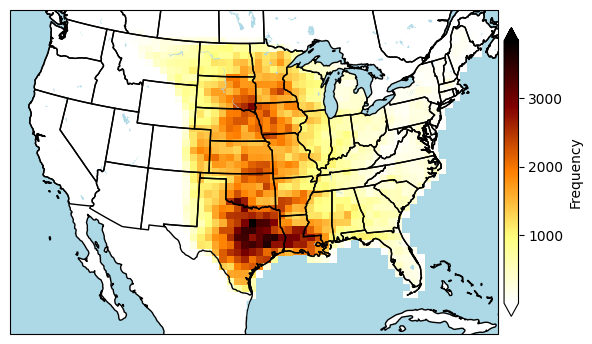

In [7]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_cor.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 1000)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

In [8]:
#load the SPC reports
#NOTE: These data have been regridded to the 80-km previously
df_obs = pd.read_csv('/home/scratch/jcorner1/syn_sev/dataframes/SPC_LSRs_regridded_tor_fix.csv')
df_obs

,Unnamed: 0.1,Unnamed: 0,om,yr,mo,dy,date,time,tz,st,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,Nearest
0,0,28866,1056,1990,10,11,1990-10-11,13:30:00,3,FL,...,20,1,1,1,17,0,0,0,0,"(675 28.726412\nName: lat, dtype: float32, ..."
1,1,28867,1057,1990,10,11,1990-10-11,13:50:00,3,FL,...,23,1,1,1,23,0,0,0,0,"(813 30.041531\nName: lat, dtype: float32, ..."
2,2,28868,1058,1990,10,11,1990-10-11,19:40:00,3,GA,...,150,1,1,1,25,0,0,0,0,"(951 31.360302\nName: lat, dtype: float32, ..."
3,3,28869,1059,1990,10,13,1990-10-13,11:35:00,3,NY,...,107,1,1,1,105,0,0,0,0,"(2129 41.887657\nName: lat, dtype: float32,..."
4,4,28870,1060,1990,10,18,1990-10-18,10:15:00,3,VA,...,33,1,1,1,137,0,0,0,0,"(1713 38.250511\nName: lat, dtype: float32,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18803,18803,48929,1166,2005,9,5,2005-09-05,19:00:00,3,ND,...,100,1,1,1,17,0,0,0,0,"(2381 46.582943\nName: lat, dtype: float32,..."
18804,18804,48930,415,2005,9,5,2005-09-05,19:04:00,3,MN,...,100,1,1,1,27,0,0,0,0,"(2381 46.582943\nName: lat, dtype: float32,..."
18805,18805,48931,333,2005,9,5,2005-09-05,19:26:00,3,KS,...,25,1,1,1,199,0,0,0,0,"(1617 39.127338\nName: lat, dtype: float32,..."
18806,18806,48932,331,2005,9,6,2005-09-06,18:53:00,3,NE,...,20,1,1,1,17,0,0,0,0,"(1895 41.86729\nName: lat, dtype: float32, ..."


In [9]:
#create an array of zeros
zeros = np.zeros((ds_cor.UP_HELI_MAX.values.shape))

#iterate through each row of the dataframe to and add one for each instance
for rid, row in df_obs.iterrows():
    y1, x1 = np.where(ds_cor.lat.values == float(row.Nearest.split()[1]))
    y2, x2 = np.where(ds_cor.lon.values == float(row.Nearest.split()[7]))
    zeros[y1[0], x2[0]] = zeros[y1[0], x2[0]] + 1
    
ds_obs = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

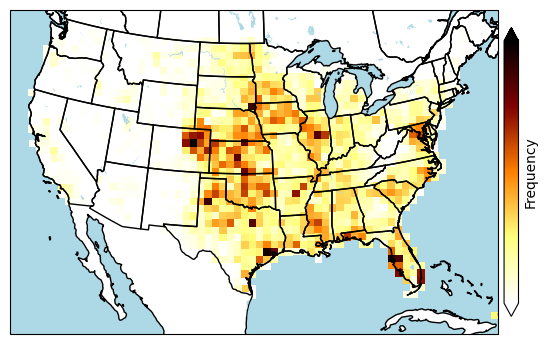

In [10]:
#Create a subplot
plt.figure(figsize=(7.5,7.5))
ax = plt.subplot(1,1,1, projection=ccrs.LambertConformal(central_longitude=-98, central_latitude=35))

#create nans for the 0 data spots
data = ds_obs.UP_HELI_MAX.values
data[data==0] = np.nan
c = ax.pcolormesh(ds_cor.lon.values, ds_cor.lat.values, data, cmap='afmhot_r', transform=cartopy.crs.PlateCarree(), vmax=int(np.nanmax(data)))

#add features to help reference map
ax.add_feature(cartopy.feature.STATES, zorder=2)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAND, facecolor='white')
ax.add_feature(cartopy.feature.OCEAN, facecolor='lightblue')
ax.add_feature(cartopy.feature.LAKES, facecolor='lightblue')
ax.set_extent([-120, -74, 20, 50])

#create colorbar
cbar = plt.colorbar(c, shrink=0.5, pad=0.01, extend='both', ticks=list(range(0, int(np.nanmax(data)), 100)), ax=ax)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label='Frequency', size=10)

### Verification with FSS

In [21]:
#create a new dataframe
df = pd.DataFrame(columns=['DBZ', 'UH', 'FSS'])

#iterate through UH and Z values for subsetting
for refc in np.arange(40,51,5):
    for uh in np.arange(60,121,5):
        
        #subset the dataframe based on current threshold values
        df_sub = df_wrf[((df_wrf['DBZ'] >= refc) & (df_wrf['UH'] >= uh))]
        
        #create an array of zeros
        zeros = np.zeros((899,1399))

        #iterate through each row of the dataframe to and add one for each instance 
        for rid, row in df_sub.iterrows():
            zeros[row['y'], row['x']] = zeros[row['y'], row['x']] + 1

        #nan all the zero values    
        zeros[zeros == 0.0] = np.nan

        #assign the array to the netcdf file
        ds = ds_copy.assign(UP_HELI_MAX = (('south_north', 'west_east'), zeros))

        #coarsen the file 
        ds_cor = Data_Conv(ds)
        
        #verify with FSS!
        fss = pysteps.verification.spatialscores.fss(ds_cor.UP_HELI_MAX.values, ds_obs.UP_HELI_MAX.values, 50, 100)
        
        print(f'UH:{uh}   DBZ:{refc}   DIFF:{len(df_obs) - len(df_sub)}   FSS:{fss}')
        df = df.append({'DBZ': refc, 'UH': uh, 'DIFF':len(df_obs) - len(df_sub), 'FSS':fss}, ignore_index=True)

UH:60   DBZ:40   DIFF:-281778   FSS:0.07889414414589935
UH:65   DBZ:40   DIFF:-223292   FSS:0.08402261075393769
UH:70   DBZ:40   DIFF:-177987   FSS:0.08745518961322785
UH:75   DBZ:40   DIFF:-142354   FSS:0.09218022844424367
UH:80   DBZ:40   DIFF:-113906   FSS:0.09832341431299962
UH:85   DBZ:40   DIFF:-91076   FSS:0.10526993338794244
UH:90   DBZ:40   DIFF:-72741   FSS:0.11157537502271808
UH:95   DBZ:40   DIFF:-57653   FSS:0.12075161303657245
UH:100   DBZ:40   DIFF:-45276   FSS:0.13158798980908015
UH:105   DBZ:40   DIFF:-34870   FSS:0.15078713162864632
UH:110   DBZ:40   DIFF:-26475   FSS:0.17494633603728227
UH:115   DBZ:40   DIFF:-19267   FSS:0.21252157104512903
UH:120   DBZ:40   DIFF:-13369   FSS:0.26025438864582295
UH:60   DBZ:45   DIFF:-204421   FSS:0.08466992350844482
UH:65   DBZ:45   DIFF:-161960   FSS:0.08898242492940978
UH:70   DBZ:45   DIFF:-128859   FSS:0.0935431980050071
UH:75   DBZ:45   DIFF:-102653   FSS:0.09999539414527958
UH:80   DBZ:45   DIFF:-81760   FSS:0.107756611939111

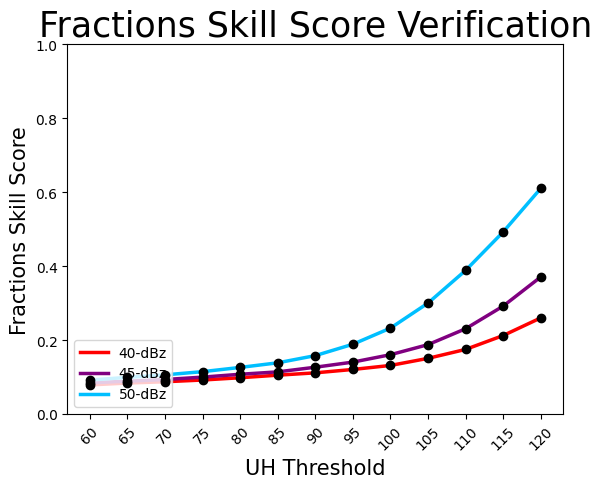

In [34]:
#plot the scores of the FSS
plt.plot(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[:13], color = 'red', lw=2.5)
plt.plot(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[13:26], color = 'purple', lw=2.5)
plt.plot(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[26:], color = 'deepskyblue', lw=2.5)

plt.scatter(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[:13], color = 'black', zorder=10)
plt.scatter(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[13:26], color = 'black', zorder=10)
plt.scatter(np.arange(1,len(np.arange(60,121,5))+1,1), df.FSS.values[26:], color = 'black', zorder=10)

plt.title('Fractions Skill Score Verification',fontsize=25)

plt.yticks(ticks = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(ticks = np.arange(1,len(np.arange(60,121,5))+1,1), labels = np.arange(60,121,5), rotation=45)

plt.xlabel('UH Threshold', size = 15)
plt.ylabel('Fractions Skill Score', size = 15)

plt.legend(['40-dBz', '45-dBz', '50-dBz'], loc ='lower left')

In [24]:
len(np.arange(35,121,5))

18

In [29]:
np.arange(35,121,5)

array([ 35,  40,  45,  50,  55,  60,  65,  70,  75,  80,  85,  90,  95,
       100, 105, 110, 115, 120])